In [1]:
#importing libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("insurance.csv")

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
categorical_features = ["sex",'smoker','region']

In [5]:
df_cat_columns = pd.get_dummies(df[categorical_features])

In [6]:
df =  df.drop(categorical_features , axis=1)

In [7]:
df = pd.concat([df,df_cat_columns],axis=1)

<h3>Data After One Hot encoding 

In [8]:
df.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


In [9]:
y = df['charges']

In [10]:
X = df.drop(['charges'], axis=1)

<h3>Normalizing

In [11]:

X.iloc[:,:] = (X.iloc[:, : ] - np.mean(X.iloc[:, :], axis=0)) / np.std(X.iloc[:, :], axis=0)

In [12]:
for col in X.columns:
    if col != 'bias':
        print(col, end=" ")
        print(round(np.mean(X[col]),3))
        print(round(np.std(X[col]),3))

age -0.0
1.0
bmi 0.0
1.0
children 0.0
1.0
sex_female 0.0
1.0
sex_male -0.0
1.0
smoker_no -0.0
1.0
smoker_yes 0.0
1.0
region_northeast -0.0
1.0
region_northwest -0.0
1.0
region_southeast 0.0
1.0
region_southwest 0.0
1.0


<h3> Function to predict and calculate Mean squared error

In [13]:
def predict(X, weights, b):
    return X @ weights + b

def MSE(weights, X, y,bias):
    return 1/2 * np.mean(np.square(predict(X, weights , bias) - y)) 

In [14]:
print(X.shape)

(1338, 11)


<h3>Function to return different train and validation set 

In [15]:
def kFold(X_p,y_p, i):
    i =  i % 10
    if i == 0:
        X_train = X_p.iloc[100:1000,:]
        X_val = X_p.iloc[0:100,:]
        y_train = y_p[100:1000]
        y_val = y_p[0:100]
    if i == 9:
        X_train = X_p.iloc[0:900,:]
        X_val = X_p.iloc[900:1000,:]
        y_train = y_p[0:900]
        y_val = y_p[900:1000]
    else:
        X_train = pd.concat([X_p.iloc[0:i*100,:] ,X_p.iloc[(i+1)*100:1000,:]] ) 
        X_val = X_p.iloc[i*100:(i+1)*100, :]
        y_train = pd.concat([y_p[0:i*100] ,y_p[(i+1)*100:1000] ])
        y_val = y_p[i*100:(i+1)*100]
    return X_train , X_val ,y_train ,y_val
    

<h3>Function to find optimal weight using Gradient Descent with regularization

In [16]:
def Linear_Ridge_Regression(X,y,alpha = 0.0001,iteration=500,showloss=False, reg_param = 1e-6):  
    m , n = X.shape
    bias=1
    weights = np.ones(X.shape[1])
    losses = []
    for i in range(iteration):
        y_pred = predict(X,weights,bias)
        delta_w = (-(2*(X.T).dot(y - y_pred)) + (2*reg_param*weights))/X.shape[0]
        delta_b = -2*np.sum(y - y_pred)/X.shape[0]
        weights -= alpha * delta_w
        bias -= alpha * delta_b
        if showloss == True:
            if i % 100 == 10:
                print(MSE(weights,X,y,bias),end = "->")
        losses.append(MSE(weights, X, y,bias))
    return X,weights,losses,bias

<h3>Function to find optimal weight using Gradient Descent with regularization and K fold validation

In [17]:
def Linear_Ridge_Regression_kfold(X,y,alpha = 0.0001,iteration=500,showloss=False, reg_param = 1e-6):  
    weights_vector = []
    bias_vector = []
    train_losses = []
    validation_losses = []
    for j in range(10):
        
        X_train , X_val ,y_train ,y_val = kFold(X,y,j)
        X_train = X_train.to_numpy()
        X_val = X_val.to_numpy()
        y_train =  y_train.to_numpy()
        y_val = y_val.to_numpy()
        bias=1
        weights = np.ones(X_train.shape[1])
        m , n = X_train.shape
#         print(" ")
        for i in range(iteration):
            y_pred = predict(X_train,weights,bias)
            delta_w = (-(2*(X_train.T).dot(y_train - y_pred)) + (2*reg_param*weights))/X_train.shape[0]
            delta_b = -2*np.sum(y_train - y_pred)/X_train.shape[0]
            weights -= alpha * delta_w
            bias -= alpha * delta_b
            if showloss == True:
                if i % 100 == 1:
                    print(MSE(weights,X_train,y_train,bias),end = "->")
        Tloss = MSE(weights,X_train,y_train,bias)
        Vloss = MSE(weights,X_val,y_val,bias)
#         print("Training losses =  ", Tloss ," ",j ,"set as Validation , Validation loss =", Vloss)
        train_losses.append(Tloss)
        validation_losses.append(Vloss)
        weights_vector.append(weights)
        bias_vector.append(bias)
    return weights_vector,bias_vector,train_losses,validation_losses

In [18]:
X_train = X.iloc[:1000,:]
y_train = y[:1000]
X_test = X.iloc[1000:-1,:]
y_test = y[1000:-1]

In [19]:

weights_vector,bias_vector,train_losses,validation_losses = Linear_Ridge_Regression_kfold(X_train,y_train,alpha = 0.01,iteration=5000,showloss=False, reg_param = 0)

<h3> Train and Validation Error on different set from K sets

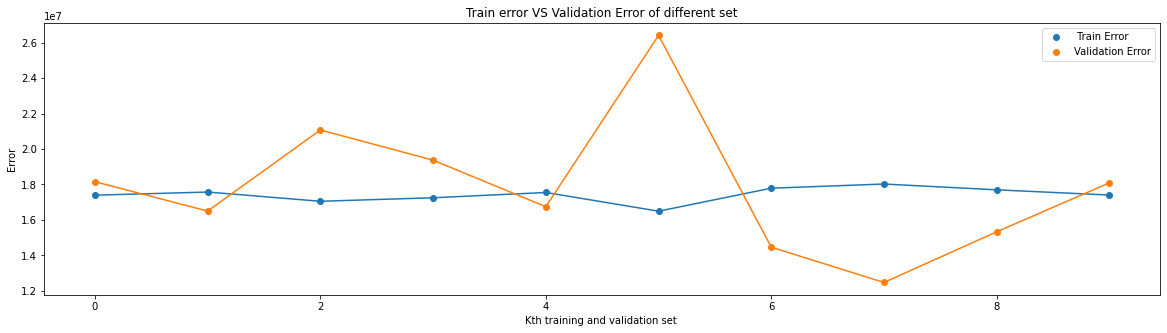

In [20]:
fig = plt.figure(figsize=(20, 5))
plt.scatter([i for i in range(10)], train_losses , label = ' Train Error')
plt.scatter([i for i in range(10)], validation_losses , label = "Validation Error")
plt.plot([i for i in range(10)], train_losses )
plt.plot([i for i in range(10)], validation_losses )
plt.xlabel("Kth training and validation set ")
plt.ylabel("Error")
plt.title("Train error VS Validation Error of different set")
plt.legend()

<h3> Finding train and validation losses with K fold and different value or regularaization parameter

In [21]:
reg_list = [0 , 0.1, 0.001,  0.0001, 5 , 100 ,1000,10000]
trainLoss_reg = []
validationLoss_reg = []
for reg in reg_list:
    weights_vector,bias_vector,train_losses,validation_losses = Linear_Ridge_Regression_kfold(X_train,
                                                                                              y_train,
                                                                                              alpha = 0.01,
                                                                                              iteration=5000,
                                                                                              showloss=False, 
                                                                                              reg_param = reg)
    trainLoss_reg.append(np.mean(train_losses))
    validationLoss_reg.append(np.mean(validation_losses))
    

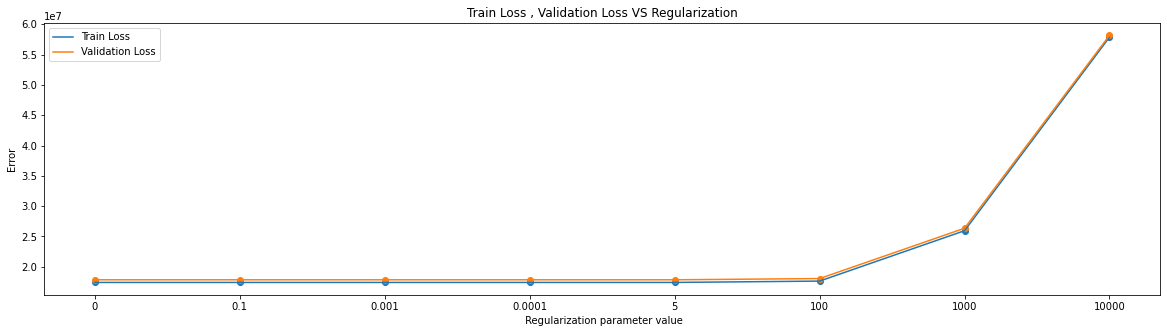

In [22]:
fig = plt.figure(figsize=(20, 5))
plt.scatter(np.arange(len(reg_list)), trainLoss_reg)
plt.scatter(np.arange(len(reg_list)), validationLoss_reg)
plt.plot(np.arange(len(reg_list)), trainLoss_reg, label= "Train Loss")
plt.plot(np.arange(len(reg_list)), validationLoss_reg , label ="Validation Loss")
plt.xlabel(" Regularization parameter value")
plt.ylabel("Error")
plt.title("Train Loss , Validation Loss VS Regularization")
plt.xticks(np.arange(len(reg_list)),labels=reg_list)
plt.legend()


In [23]:
reg_list = [0 , 0.1, 0.01,  0.001, 5 ,20 , 100 ,1000,10000]
TrainLoss_reg=[]
TestLoss_reg=[]
variance_log=[]
for reg in reg_list:
    X_train,weights,losses,bias = Linear_Ridge_Regression(X_train, y_train, alpha = 0.01, iteration=5000,
                                                                                              showloss=False, 
                                                                                              reg_param = reg)
    TrainLoss_reg.append(MSE(weights,X_train,y_train,bias))
    TestLoss_reg.append(MSE(weights,X_test,y_test,bias))
    variance =  np.var(predict(X_test,weights,bias))
    variance_log.append(variance)
    



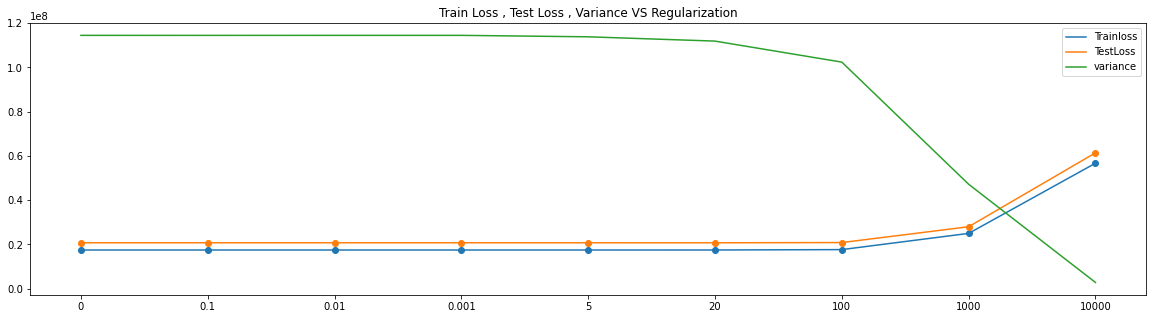

In [24]:
fig = plt.figure(figsize=(20, 5))
plt.scatter(np.arange(len(reg_list)), TrainLoss_reg)
plt.scatter(np.arange(len(reg_list)), TestLoss_reg)
plt.plot(np.arange(len(reg_list)), TrainLoss_reg,label="Trainloss")
plt.plot(np.arange(len(reg_list)), TestLoss_reg, label = "TestLoss")
plt.plot(np.arange(len(reg_list)), variance_log,label = "variance")
plt.title("Train Loss , Test Loss , Variance VS Regularization")
plt.xticks(np.arange(len(reg_list)),labels=reg_list)
plt.legend()

In [25]:
X_train,weights,losses,bias = Linear_Ridge_Regression(X_train, y_train, alpha = 0.01, iteration=10000,
                                                                                              showloss=False, 
                                                                                              reg_param = 0.1)


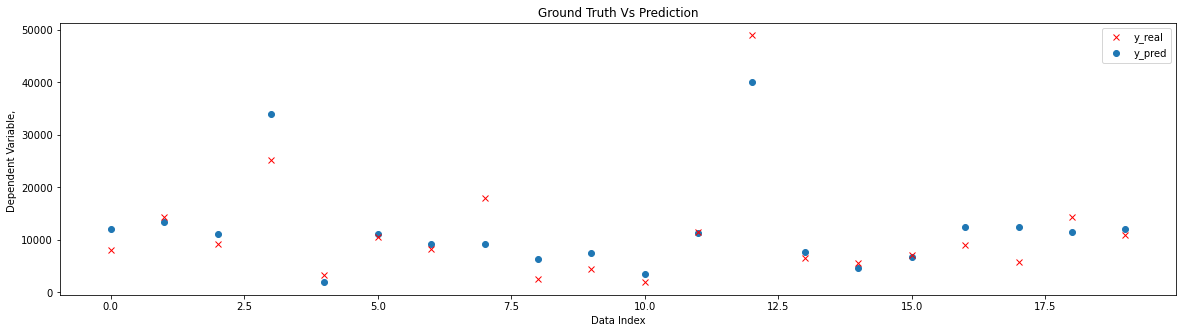

In [26]:
fig = plt.figure(figsize=(20, 5))
y_pred = predict(X_test,weights,bias)
plt.scatter([i for i in range(len(y_test[50:70]))],y_pred[50:70],label='y_pred')
plt.plot([i for i in range(len(y_test[50:70]))],y_test[50:70],'rx',label="y_real")
plt.xlabel("Data Index")
plt.ylabel("Dependent Variable, ")
plt.title("Ground Truth Vs Prediction")
plt.legend()